<a href="https://colab.research.google.com/github/dipakp2726/Recipe-Master/blob/devlope/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libs


In [26]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

In [27]:
print(tf.__version__)

2.4.0


In [25]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# setting path to dataset and parameters

In [28]:
data_dir ='/content/drive/MyDrive/Recipe Master/dataset/dataset' 
data_dir = pathlib.Path(data_dir)

In [29]:
batch_size = 32
img_height = 224
img_width = 224
IMG_SIZE = (img_height,img_width)

# spliting validation,test and train data

In [30]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 2400 files for training.


In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [32]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 16
Number of test batches: 3


# printing class names and random images from dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Handvo', 'Khaman', 'Khandvi', 'Muthiya', 'Thepla', 'Undhiyu']


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# datapreprocessing

In [33]:
# normalizing img weights

rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [34]:
# data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
   
  ]
)

In [ ]:
# augmentation preview
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# model creation

In [35]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, 
                                                    pooling='avg', classes=1000)

# DenseNet169

In [36]:
base_model.trainable=False


In [37]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [38]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')

In [39]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = rescale(inputs)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [40]:
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 42,670,470
Trainable params: 12,294
Non-trainable params: 42,658,176
_________________________________________________________________


In [21]:
loss0, accuracy0 = model.evaluate(val_ds)

16/16 [==============================] - 117s 3s/step - loss: 2.8797 - accuracy: 0.1804


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.95
initial accuracy: 0.16


## Callbacks

In [23]:
!mkdir checkpoint
checkpoint_path = "/content/checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

## traing model

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
initial_epochs = 38
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/38
75/75 [==============================] - 52s 559ms/step - loss: 1.7158 - accuracy: 0.3858 - val_loss: 0.7386 - val_accuracy: 0.7401
Epoch 2/38
75/75 [==============================] - 9s 122ms/step - loss: 0.7972 - accuracy: 0.7330 - val_loss: 0.6176 - val_accuracy: 0.8016
Epoch 3/38
75/75 [==============================] - 9s 122ms/step - loss: 0.6259 - accuracy: 0.7887 - val_loss: 0.5458 - val_accuracy: 0.8313
Epoch 4/38
75/75 [==============================] - 9s 122ms/step - loss: 0.5479 - accuracy: 0.8178 - val_loss: 0.5307 - val_accuracy: 0.8294
Epoch 5/38
21/75 [=======>......................] - ETA: 5s - loss: 0.4958 - accuracy: 0.8484

## plotting accuracy

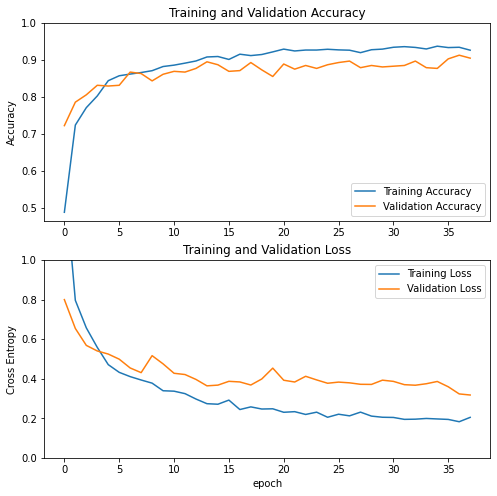

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# sparce_acc = history.history['sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.plot(sparce_acc, label='sparse_categorical_accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

model.save('/content/drive/MyDrive/Recipe Master/colab/saved model/resnet101with_6')

In [28]:

loss0, accuracy0 = model.evaluate(test_ds)

3/3 [==============================] - 4s 289ms/step - loss: 0.4981 - accuracy: 0.8854


In [29]:
print("test loss: {:.2f}".format(loss0))
print("test accuracy: {:.2f}".format(accuracy0))

test loss: 0.50
test accuracy: 0.89
